In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
import shapely
from itertools import combinations

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures/insitu')

In [8]:
ncs_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs')
ds = xr.open_dataset(ncs_dir.joinpath('final_uv_geom_atm_veg_model_v1.nc')).isel(x = slice(0, -1, 100), y = slice(0, -1, 100))
ds = ds.sortby('time1')

In [9]:
data_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/data')
insitu_dir = data_dir.joinpath('insitu')
insitu = pd.read_parquet(insitu_dir.joinpath('all_difference.parq'))
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")

In [12]:
ds['unw_atm'] = ds['unw'] - ds['delay']
ds['int_atm'] = ds['int_phase'] - ds['delay']

In [13]:
inc_mean = ds['inc'].mean()
for t1 in insitu.time1.unique():
    insitu_time = insitu[insitu.time1 == t1]
    insitu_dSD = insitu_time['dSD'].mean()
    insitu_density = pd.concat([insitu_time['t1_density'], insitu_time['t2_density']]).mean()
    expected_phase = phase_from_depth(insitu_dSD, inc_angle = inc_mean, density = insitu_density)
    print(f'Insitu dSD: {insitu_dSD}. expected phase: {expected_phase.data}')
    for k in ['unw', 'unw_atm', 'int_phase', 'int_atm']:
        t2 = insitu_time.iloc[0]['time2']
        snow_on = (ds['model_swe'].sel(time = t1) > 0.1) & (ds['model_swe'].sel(time = t2) > 0.1)
        cur_phase = ds[k].sel(time1 = t1).where(snow_on).mean()
        print(f'{k }Current phase: {cur_phase.data}')
        ds[k].loc[{'time1':t1}] = ds[k].sel(time1 = t1) - (cur_phase - expected_phase)
        print(f'{k} New phase {ds[k].sel(time1 = t1).mean().data}')
        print('')

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Insitu dSD: 0.12117499999999999. expected phase: 2.1323776119816418
unwCurrent phase: -0.17784851631956083
unw New phase 2.0208406110209145

unw_atmCurrent phase: 0.16987597583887748
unw_atm New phase 2.0462304477487168

int_phaseCurrent phase: -0.15239919617651182
int_phase New phase 2.0275664986073276

int_atmCurrent phase: 0.16566136162011466
int_atm New phase 2.0536945415128254

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Insitu dSD: 0.02019999999999998. expected phase: 0.3507192738283656
unwCurrent phase: -0.8185337643542153
unw New phase 0.5810924479932731

unw_atmCurrent phase: 0.07961642598040254
unw_atm New phase 0.5319578717355923

int_phaseCurrent phase: -0.7268560238880465
int_phase New phase 0.5598929717038477

int_atmCurrent phase: 0.15963054690921136
int_atm New phase 0.5167321939551641

No permittivity da

In [14]:
for k in ['unw', 'unw_atm', 'int_phase', 'int_atm']:
    for i,r in insitu.iterrows():
        tol = 0.00090009*5
        int_phase = ds.sel(time1 = r.time1)[k].sel(x = slice(r.geometry.x - tol, r.geometry.x + tol) , y = slice(r.geometry.y+tol, r.geometry.y - tol)).mean().data.ravel()[0]
        int_sd = depth_from_phase(int_phase, r.inc, density = r.t1_density)
        insitu.loc[i,f'{k}_sd'] = int_sd

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating p

(-0.42, 0.42)

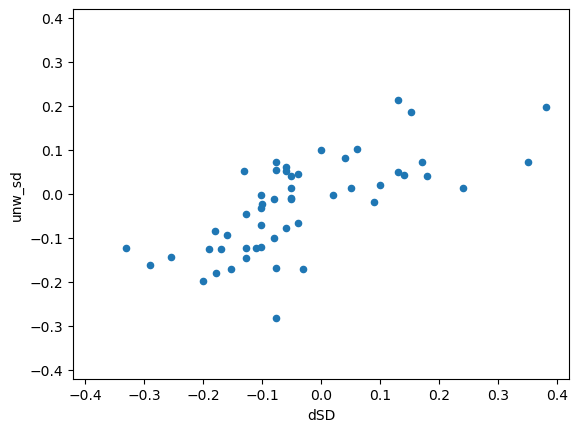

In [17]:
insitu.plot.scatter(x = 'dSD', y = 'unw_sd')
plt.xlim(-0.42, 0.42)
plt.ylim(-0.42, 0.42)

(-0.3, 0.3)

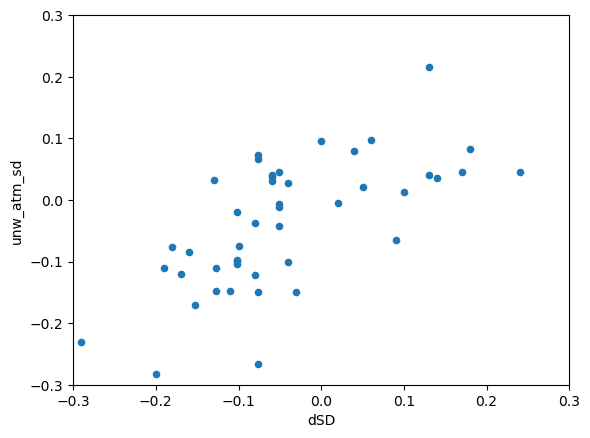

In [16]:
insitu.plot.scatter(x = 'dSD', y = 'unw_atm_sd')
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)